In [ ]:
# default_exp funcs.train_funcs

In [ ]:
%load_ext autoreload
%autoreload 2

# Training loop simulator learning

In [ ]:
#export
from decode_fish.imports import *
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.plotting import *
import torch.nn.functional as F
from torch import distributions as D
from torch.utils.data import DataLoader
import torch_optimizer
from decode_fish.engine.microscope import Microscope
from decode_fish.engine.model import UnetDecodeNoBn
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.engine.gmm_loss import PointProcessGaussian
import shutil
import wandb

from hydra import compose, initialize
from decode_fish.funcs.merfish_eval2 import *
# from decode_fish.funcs.visualization vimport get_simulation_statistics

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [ ]:
#export
def eval_logger(pred_df, target_df, iteration, data_str='Sim. '):
    
    perf_dict,matches,shift = matching(target_df, pred_df, print_res=False)
    if 'Inp' in data_str:
        pred_corr = shift_df(pred_df, shift)
        perf_dict, _, _ = matching(target_df, pred_corr, print_res=False)

    wandb.log({data_str +'Metrics/eff_3d': perf_dict['eff_3d']}, step=iteration)
    wandb.log({data_str +'Metrics/jaccard': perf_dict['jaccard']}, step=iteration)
    wandb.log({data_str +'Metrics/rmse_vol': perf_dict['rmse_vol']}, step=iteration)

    wandb.log({data_str +'Metrics/precision': perf_dict['precision']}, step=iteration)
    wandb.log({data_str +'Metrics/recall': perf_dict['recall']}, step=iteration)
    wandb.log({data_str +'Metrics/rmse_x': perf_dict['rmse_x']}, step=iteration)
    wandb.log({data_str +'Metrics/rmse_y': perf_dict['rmse_y']}, step=iteration)
    wandb.log({data_str +'Metrics/rmse_z': perf_dict['rmse_z']}, step=iteration)   
    
    return matches
    
def load_from_eval_dict(eval_dict):
    
    eval_img = load_tiff_image(sorted(glob.glob(eval_dict['image_path']))[eval_dict['img_ind']])#[eval_dict['sm_fish_ch']][None]
    eval_img = eval_img[eval_dict['crop_sl']]
    eval_df = None
    eval_psf = None
    if eval_dict['txt_path'] is not None:
        txt_path = sorted(glob.glob(eval_dict['txt_path']))[eval_dict['img_ind']]
        eval_df = simfish_to_df(txt_path)
        eval_df = crop_df(eval_df, eval_dict['crop_sl'], px_size_zyx=eval_dict['px_size_zyx'])

    if eval_dict['psf_path'] is not None:
        eval_psf = load_tiff_image(eval_dict['psf_path'])
        
    return eval_img, eval_df, eval_psf

def save_train_state(save_dir, model, microscope, optim_dict, train_iter):
    
        torch.save({'state_dict':model.state_dict(), 'scaling':[model.inp_scale, model.inp_offset]}, save_dir/'model.pkl')
        torch.save(microscope.state_dict(), save_dir/'microscope.pkl')
        
        save_dict = {k:v.state_dict() for (k,v) in optim_dict.items()}
        save_dict['train_iter'] = train_iter
        
        torch.save(save_dict, save_dir/'training_state.pkl')

In [ ]:
#export
def train(cfg,
          model, 
          microscope,
          post_proc,
          dl, 
          optim_dict,
          eval_dict=None):
    
    """
    Training loop for autoencoder learning. Alternates between a simulator training step to train the inference network
    and an autoencoder step to train the PSF (and microscope) parameters.
    
    Args:
        model (torch.nn.Module): DECODE 3D UNet.
        dl  (torch.utils.data.dataloader.DataLoader): Dataloader that returns a random sub volume from the real volume, an estiamted emitter density and background.
        optim_net  (torch.optim.Optimizer): Optimizer for the network parameters.
        optim_mic  (torch.optim.Optimizer): Optimizer for the PSF parameters.
        sched_net  (torch.optim.lr_scheduler): LR scheduler for the network parameters.
        sched_mic  (torch.optim.lr_scheduler): LR scheduler for the PSF parameters.
        microscope (torch.nn.Module): Microscope class that transforms emitter locations into simulated images.
        eval_dict  (dict, optional): Dictionary with evaluation parameters
        
    """ 
    
    save_dir = Path(cfg.output.save_dir)
    
    if eval_dict is not None:
        eval_img, eval_df, eval_psf = load_from_eval_dict(eval_dict)

    model.cuda().train()
    torch.save(microscope.psf.state_dict(), str(save_dir) + '/psf_init.pkl' )
    
    _, code_ref, _ = get_benchmark()
    code_inds = np.stack([np.nonzero(c)[0] for c in code_ref])
    
    for batch_idx in range(cfg.training.start_iter, cfg.training.num_iters):
        
#         t0 = time.time()
        x, local_rate, background = next(iter(dl))
        
#         print('Iter ', time.time()-t0); t0 = time.time()
        
        optim_dict['optim_net'].zero_grad()
        
        sim_vars = PointProcessUniform(local_rate, int_conc=model.int_dist.int_conc.detach(), 
                                       int_rate=model.int_dist.int_rate.detach(), int_loc=model.int_dist.int_loc.detach(), 
                                       sim_iters=5, channels=cfg.exp_type.channels, n_bits=cfg.exp_type.n_bits, 
                                       sim_z=cfg.exp_type.pred_z, codebook=torch.tensor(code_inds)).sample(from_code_book=cfg.exp_type.sample_from_codebook)
        
        # sim_vars = locs_sl, x_os_sl, y_os_sl, z_os_sl, ints_sl, output_shape
        xsim = microscope(*sim_vars, add_noise=True)
        xsim_noise = microscope.noise(xsim, background).sample()
        
        out_sim = model.tensor_to_dict(model(xsim_noise))

        count_prob, spatial_prob = PointProcessGaussian(**out_sim).log_prob(*sim_vars[:5], n_bits=cfg.exp_type.n_bits, 
                                                                            channels=cfg.exp_type.channels, min_int_sig=cfg.training.net.min_int_sig)
        gmm_loss = -(spatial_prob + cfg.training.net.cnt_loss_scale*count_prob).mean()
        
        background_loss = F.mse_loss(out_sim['background'], background) * cfg.training.net.bl_loss_scale

        loss = gmm_loss + background_loss
        
        # Update network parameters
        loss.backward()
        
        if cfg.training.net.grad_clip: torch.nn.utils.clip_grad_norm_(model.network.parameters(), max_norm=cfg.training.net.grad_clip, norm_type=2)

        optim_dict['optim_net'].step()
        optim_dict['sched_net'].step()
        
#         print('SL ', time.time()-t0); t0 = time.time()
            
        if batch_idx > min(cfg.training.start_mic,cfg.training.start_int):
            
            out_inp = model.tensor_to_dict(model(x))
            rand_ch = torch.randint(0,cfg.exp_type.channels, size=[1])[0]
            locations, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape = post_proc.get_micro_inp(out_inp, channel=rand_ch) 
            # locations, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape
            filt_inds = [ints_3d >  model.int_dist.int_loc.detach()]
            locations = [l[filt_inds] for l in locations]
            x_os_3d, y_os_3d, z_os_3d, ints_3d = x_os_3d[filt_inds], y_os_3d[filt_inds], z_os_3d[filt_inds], ints_3d[filt_inds]
            proc_out_inp = locations, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape
            
            if cfg.training.mic.enabled and batch_idx > cfg.training.start_mic:
                
                optim_dict['optim_mic'].zero_grad()

                # Get autoencoder loss
                ae_img = microscope(*proc_out_inp, add_noise=False, rec_ch=rand_ch)
                
                log_p_x_given_z = -microscope.noise(ae_img,out_inp['background'],rec_ch=rand_ch).log_prob(x[:,rand_ch:rand_ch+1]).mean()
                if cfg.training.mic.norm_reg:
                    log_p_x_given_z += cfg.training.mic.norm_reg * (microscope.psf.com_loss())
                    
                log_p_x_given_z.backward()
                if cfg.training.mic.grad_clip:
                    torch.nn.utils.clip_grad_norm_(microscope.parameters(), max_norm=cfg.training.mic.grad_clip, norm_type=2)
                    
                optim_dict['optim_mic'].step()
                optim_dict['sched_mic'].step()
                
#                 print('PSF ', time.time()-t0); t0 = time.time()
            
            if  cfg.training.int.enabled and batch_idx > cfg.training.start_int and len(proc_out_inp[4]):
                
                optim_dict['optim_int'].zero_grad()
                ints = proc_out_inp[4]
                ints = torch.clamp_min(ints, model.int_dist.int_loc.detach() + 0.01)

                gamma_int = D.Gamma(model.int_dist.int_conc, model.int_dist.int_rate)
                loc_trafo = [D.AffineTransform(loc=model.int_dist.int_loc, scale=1)]
                int_loss = -D.TransformedDistribution(gamma_int, loc_trafo).log_prob(ints.detach()).mean()
                
                if cfg.training.int.grad_clip:
                    torch.nn.utils.clip_grad_norm_(model.int_dist.parameters(), max_norm=cfg.training.mic.grad_clip, norm_type=2)
                
                int_loss.backward()
                optim_dict['optim_int'].step()
                optim_dict['sched_int'].step()
                
#                 print('INT ', time.time()-t0); t0 = time.time()

        # Logging
        if batch_idx % 10 == 0:
            wandb.log({'SL Losses/xyz_loss': spatial_prob.mean().detach().cpu().item()}, step=batch_idx)
#             wandb.log({'SL Losses/ints_loss': int_prob.mean().detach().cpu().item()}, step=batch_idx)
            wandb.log({'SL Losses/count_loss': (-count_prob.mean()).detach().cpu()}, step=batch_idx)
            wandb.log({'SL Losses/bg_loss': background_loss.detach().cpu()}, step=batch_idx)
            wandb.log({'AE Losses/int_mu': model.int_dist.int_conc.item()/model.int_dist.int_rate.item() + model.int_dist.int_loc.item()}, step=batch_idx)
            wandb.log({'AE Losses/int_rate': model.int_dist.int_rate.item()}, step=batch_idx)
            wandb.log({'AE Losses/int_loc': model.int_dist.int_loc.item()}, step=batch_idx)
            wandb.log({'AE Losses/theta': microscope.noise.theta_par.cpu().detach().mean().item()*microscope.noise.theta_scale}, step=batch_idx)

            if batch_idx > cfg.training.start_mic: 
                if cfg.training.mic.enabled:
                    wandb.log({'AE Losses/p_x_given_z': log_p_x_given_z.detach().cpu()}, step=batch_idx)
                    wandb.log({'AE Losses/RMSE(rec)': torch.sqrt(((x[:,:1]-(ae_img+out_inp['background']))**2).mean()).detach().cpu()}, step=batch_idx)
                    wandb.log({'AE Losses/sum(psf)': F.relu(microscope.psf.psf_volume/microscope.psf.psf_volume.max())[0].sum().detach().cpu()}, step=batch_idx)
#                     wandb.log({'AE Losses/theta': microscope.theta.item()}, step=batch_idx)
        
        if batch_idx % cfg.output.log_interval == 0:
            print(batch_idx)
            with torch.no_grad():
                
                pred_df = post_proc.get_df(out_sim)
                px_size = cfg.evaluation.px_size_zyx
                target_df = sample_to_df(*sim_vars[:5], px_size_zyx=px_size)
                matches = eval_logger(pred_df, target_df, batch_idx, data_str='Sim. ')
                
                try:
                    int_corrs = [np.corrcoef(matches[f'int_pred_{i}'],matches[f'int_tar_{i}'])[0,1] for i in range(16)]
                except ZeroDivisionError:
                    int_corrs = [0]
                    
                wandb.log({'Sim. Metrics/int_corrs': np.mean(int_corrs)}, step=batch_idx)
                
                wandb.log({'Sim. Metrics/prob_fac': torch.sigmoid(out_sim['logits']).sum().item()/(len(target_df)+0.1)}, step=batch_idx)
                wandb.log({'Sim. Metrics/n_em_fac': len(pred_df)/(len(target_df)+0.1)}, step=batch_idx)
#                 wandb.log({'Prob hist': wandb.Image(plot_prob_hist(out_sim))}, step=batch_idx)

                if cfg.output.log_figs:
            
                    sl_fig = sl_plot(x, xsim_noise, nm_to_px(pred_df, px_size), nm_to_px(target_df, px_size), background, out_sim)
                    plt.show()
                    wandb.log({'SL summary': sl_fig}, step=batch_idx)

                if eval_dict is not None:

                    res_eval = model.tensor_to_dict(model(eval_img[None].cuda()))
                    ae_img = microscope(*post_proc.get_micro_inp(res_eval)[:6])
                    pred_eval_df = post_proc.get_df(res_eval)
                    wandb.log({'AE Losses/N preds(eval)': len(pred_eval_df)}, step=batch_idx)
                    
                    if eval_df is not None:
                        eval_logger(pred_eval_df, eval_df, batch_idx, data_str='Inp. ')
                        
                    if eval_psf is not None:
                        wandb.log({'AE Losses/Corr(psf)': np.corrcoef(cpu(eval_psf).reshape(-1), cpu(microscope.psf.psf_volume).reshape(-1))[0,1]}, step=batch_idx)
                        wandb.log({'AE Losses/RMSE(psf)': np.sqrt(np.mean((cpu(eval_psf/eval_psf.max())-cpu(microscope.psf.psf_volume/microscope.psf.psf_volume.max()))**2))}, step=batch_idx)
        
                    if cfg.output.log_figs:
                        eval_fig = gt_plot(eval_img, nm_to_px(pred_eval_df, px_size), nm_to_px(eval_df, px_size), px_size,ae_img[0]+res_eval['background'][0], microscope.psf)
                        plt.show()
                        wandb.log({'GT': eval_fig}, step=batch_idx)

            # storing
            save_train_state(save_dir, model, microscope, optim_dict, batch_idx) 
            
    wandb.finish()

In [ ]:
cfg = OmegaConf.load('../config/experiment/MERFISH_ci_2d_tffn.yaml')
cfg.run_name = 'test'

cfg.training.bs = 3
cfg.training.mic.enabled = True
cfg.training.int.enabled = False
cfg.foci.n_foci_avg = 0
# cfg.exp_type.pred_z = True

# cfg.exp_type.pred_z = True

psf, noise, micro = load_psf_noise_micro(cfg)
post_proc = hydra.utils.instantiate(cfg.post_proc_isi)

In [ ]:
img_3d, decode_dl = get_dataloader(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
1 volumes


In [ ]:
inp_offset, inp_scale = get_forward_scaling(img_3d[0])
model = hydra.utils.instantiate(cfg.model, inp_scale=float(inp_scale), inp_offset=float(inp_offset))

psf  .to('cuda')
model.to('cuda')
micro.to('cuda')

Microscope(
  (psf): LinearInterpolatedPSF(
    (forward_nonlin): Identity()
  )
  (noise): sCMOS()
)

In [ ]:
optim_dict = {}
optim_dict['optim_net'] = hydra.utils.instantiate(cfg.training.net.opt, params=model.parameters())
optim_dict['optim_mic'] = hydra.utils.instantiate(cfg.training.mic.opt, params=micro.parameters())
optim_dict['optim_int'] = hydra.utils.instantiate(cfg.training.int.opt, params=model.int_dist.parameters())

optim_dict['sched_net'] = hydra.utils.instantiate(cfg.training.net.sched, optimizer=optim_dict['optim_net'])
optim_dict['sched_mic'] = hydra.utils.instantiate(cfg.training.mic.sched, optimizer=optim_dict['optim_mic'])
optim_dict['sched_int'] = hydra.utils.instantiate(cfg.training.int.sched, optimizer=optim_dict['optim_int'])

if cfg.evaluation is not None:
    eval_dict = dict(cfg.evaluation)
    eval_dict['crop_sl'] = eval(eval_dict['crop_sl'],{'__builtins__': None},{'s_': np.s_})
    eval_dict['px_size_zyx'] = list(eval_dict['px_size_zyx'])
else:
    eval_dict = None
    
save_dir = Path(cfg.output.save_dir)
save_dir.mkdir(exist_ok=True, parents=True)

In [ ]:
# Resume training from a previous checkpoint

# cfg.data_path.model_init = cfg.output.save_dir
if cfg.data_path.model_init is not None:
    print('loading')
    model = load_model_state(model, Path(cfg.data_path.model_init)/'model.pkl').cuda()
    micro.load_state_dict(torch.load(Path(cfg.data_path.model_init)/'microscope.pkl'))
    
    train_state_dict = torch.load(Path(cfg.data_path.model_init)/'training_state.pkl')
    for k in optim_dict:
        optim_dict[k].load_state_dict(train_state_dict[k])
        
    cfg.training.start_iter = train_state_dict['train_iter']

In [ ]:
# point_process = PointProcessUniform(local_rate = torch.ones([2,1,48,48,48]).cuda()*.0001, min_int = 0.5, sim_iters=5)
# locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape = point_process.sample()

In [ ]:
# xsim = micro(locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape)
# plot_3d_projections(xsim[0,0])

In [ ]:
_ = wandb.init(project=cfg.output.project, 
               config=OmegaConf.to_container(cfg, resolve=True),
               dir=cfg.output.log_dir,
               group=cfg.output.group,
               name=cfg.run_name,
               mode='disabled'
          )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


tensor([[[[[1.5000]]],


         [[[1.5000]]],


         [[[1.5000]]],


         [[[1.5000]]],


         [[[1.5000]]],


         [[[1.5000]]],


         [[[1.5000]]],


         [[[1.5000]]],


         [[[1.5000]]],


         [[[1.5000]]],


         [[[1.5000]]],


         [[[1.5000]]],


         [[[1.5000]]],


         [[[1.5000]]],


         [[[1.5000]]],


         [[[1.5000]]]]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)
0


/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)


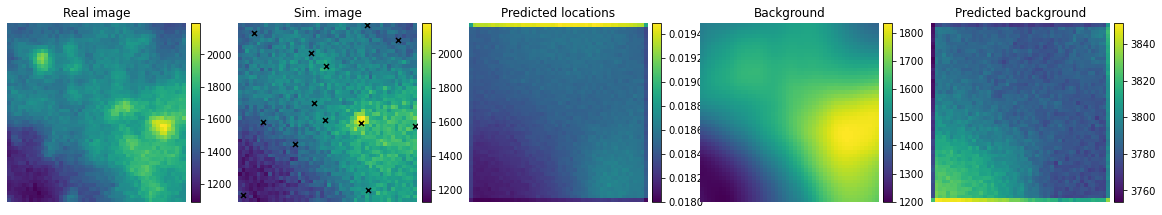

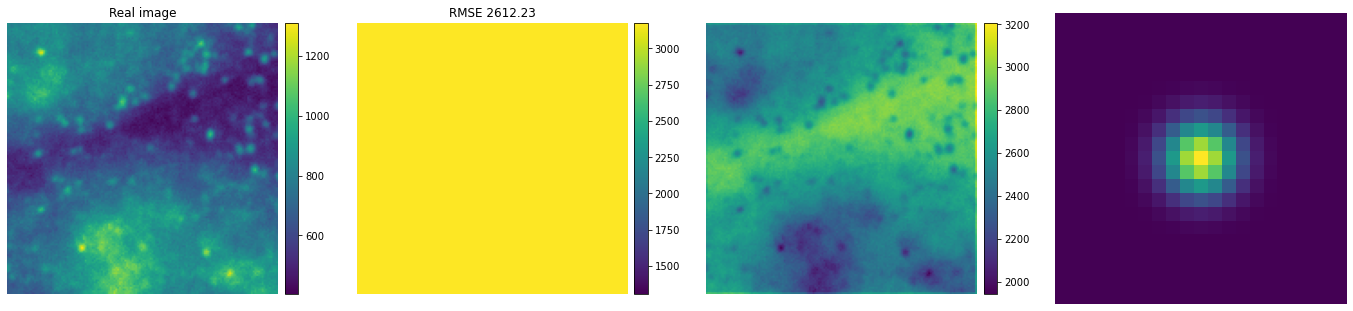

tensor([[[[[1.5000]]],


         [[[1.5000]]],


         [[[1.5000]]],


         [[[1.5000]]],


         [[[1.5000]]],


         [[[1.5000]]],


         [[[1.5000]]],


         [[[1.5000]]],


         [[[1.5000]]],


         [[[1.5000]]],


         [[[1.5000]]],


         [[[1.5000]]],


         [[[1.5000]]],


         [[[1.5000]]],


         [[[1.5000]]],


         [[[1.5000]]]]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)
tensor([[[[[1.5000]]]]], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[[[[1.5000]]],


         [[[1.5000]]],


         [[[1.5000]]],


         [[[1.5000]]],


         [[[1.5000]]],


         [[[1.5000]]],


         [[[1.5000]]],


         [[[1.5000]]],


         [[[1.5000]]],


         [[[1.5000]]],


         [[[1.5000]]],


         [[[1.5060]]],


         [[[1.5000]]],


         [[[1.5000]]],


         [[[1.5000]]],


         [[[1.5000]]]]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)
tensor([[[[[1.5000]]],


         [[[1.5

tensor([[[[[1.5265]]],


         [[[1.5359]]],


         [[[1.5373]]],


         [[[1.5369]]],


         [[[1.5497]]],


         [[[1.5309]]],


         [[[1.5338]]],


         [[[1.5429]]],


         [[[1.5265]]],


         [[[1.5265]]],


         [[[1.5390]]],


         [[[1.5357]]],


         [[[1.5332]]],


         [[[1.5265]]],


         [[[1.5265]]],


         [[[1.5265]]]]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)
tensor([[[[[1.5332]]]]], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[[[[1.5272]]],


         [[[1.5374]]],


         [[[1.5384]]],


         [[[1.5381]]],


         [[[1.5527]]],


         [[[1.5333]]],


         [[[1.5359]]],


         [[[1.5449]]],


         [[[1.5272]]],


         [[[1.5272]]],


         [[[1.5416]]],


         [[[1.5364]]],


         [[[1.5358]]],


         [[[1.5272]]],


         [[[1.5272]]],


         [[[1.5272]]]]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)
tensor([[[[[1.5527]]]]], device='cuda:0'

tensor([[[[[1.5502]]],


         [[[1.5629]]],


         [[[1.5647]]],


         [[[1.5755]]],


         [[[1.5910]]],


         [[[1.5539]]],


         [[[1.5537]]],


         [[[1.5736]]],


         [[[1.5669]]],


         [[[1.5450]]],


         [[[1.5745]]],


         [[[1.5534]]],


         [[[1.5622]]],


         [[[1.5428]]],


         [[[1.5420]]],


         [[[1.5612]]]]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)
tensor([[[[[1.5736]]]]], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[[[[1.5510]]],


         [[[1.5647]]],


         [[[1.5659]]],


         [[[1.5795]]],


         [[[1.5926]]],


         [[[1.5545]]],


         [[[1.5542]]],


         [[[1.5764]]],


         [[[1.5693]]],


         [[[1.5456]]],


         [[[1.5757]]],


         [[[1.5559]]],


         [[[1.5630]]],


         [[[1.5434]]],


         [[[1.5425]]],


         [[[1.5624]]]]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)
tensor([[[[[1.5434]]]]], device='cuda:0'

tensor([[[[[1.5792]]],


         [[[1.5796]]],


         [[[1.5769]]],


         [[[1.6257]]],


         [[[1.6097]]],


         [[[1.5712]]],


         [[[1.5600]]],


         [[[1.6061]]],


         [[[1.6128]]],


         [[[1.5828]]],


         [[[1.6026]]],


         [[[1.5944]]],


         [[[1.5803]]],


         [[[1.5793]]],


         [[[1.5606]]],


         [[[1.5794]]]]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)
tensor([[[[[1.5712]]]]], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[[[[1.5811]]],


         [[[1.5802]]],


         [[[1.5775]]],


         [[[1.6278]]],


         [[[1.6112]]],


         [[[1.5752]]],


         [[[1.5603]]],


         [[[1.6078]]],


         [[[1.6154]]],


         [[[1.5877]]],


         [[[1.6045]]],


         [[[1.5975]]],


         [[[1.5824]]],


         [[[1.5823]]],


         [[[1.5652]]],


         [[[1.5827]]]]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)
tensor([[[[[1.5811]]],


         [[[1.5

tensor([[[[[1.6025]]],


         [[[1.6178]]],


         [[[1.6001]]],


         [[[1.6533]]],


         [[[1.6264]]],


         [[[1.6362]]],


         [[[1.5952]]],


         [[[1.6301]]],


         [[[1.6364]]],


         [[[1.6283]]],


         [[[1.6195]]],


         [[[1.6353]]],


         [[[1.6105]]],


         [[[1.6083]]],


         [[[1.6206]]],


         [[[1.6236]]]]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)
tensor([[[[[1.6178]]]]], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[[[[1.6031]]],


         [[[1.6235]]],


         [[[1.6009]]],


         [[[1.6546]]],


         [[[1.6283]]],


         [[[1.6381]]],


         [[[1.5980]]],


         [[[1.6307]]],


         [[[1.6370]]],


         [[[1.6294]]],


         [[[1.6200]]],


         [[[1.6367]]],


         [[[1.6124]]],


         [[[1.6090]]],


         [[[1.6227]]],


         [[[1.6261]]]]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)
tensor([[[[[1.6200]]]]], device='cuda:0'

tensor([[[[[1.6076]]],


         [[[1.6710]]],


         [[[1.6068]]],


         [[[1.6641]]],


         [[[1.6526]]],


         [[[1.6928]]],


         [[[1.6185]]],


         [[[1.6498]]],


         [[[1.6531]]],


         [[[1.6587]]],


         [[[1.6529]]],


         [[[1.6513]]],


         [[[1.6267]]],


         [[[1.6262]]],


         [[[1.6589]]],


         [[[1.6454]]]]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)
tensor([[[[[1.6262]]]]], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[[[[1.6077]]],


         [[[1.6736]]],


         [[[1.6070]]],


         [[[1.6643]]],


         [[[1.6537]]],


         [[[1.6959]]],


         [[[1.6191]]],


         [[[1.6504]]],


         [[[1.6544]]],


         [[[1.6627]]],


         [[[1.6542]]],


         [[[1.6534]]],


         [[[1.6271]]],


         [[[1.6312]]],


         [[[1.6603]]],


         [[[1.6460]]]]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)
tensor([[[[[1.6643]]]]], device='cuda:0'

tensor([[[[[1.6290]]],


         [[[1.6936]]],


         [[[1.6367]]],


         [[[1.6814]]],


         [[[1.6620]]],


         [[[1.7263]]],


         [[[1.6242]]],


         [[[1.6898]]],


         [[[1.6808]]],


         [[[1.7128]]],


         [[[1.6797]]],


         [[[1.6763]]],


         [[[1.6558]]],


         [[[1.6729]]],


         [[[1.6947]]],


         [[[1.6589]]]]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)
tensor([[[[[1.6947]]]]], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[[[[1.6298]]],


         [[[1.6941]]],


         [[[1.6410]]],


         [[[1.6819]]],


         [[[1.6622]]],


         [[[1.7282]]],


         [[[1.6243]]],


         [[[1.6927]]],


         [[[1.6819]]],


         [[[1.7148]]],


         [[[1.6812]]],


         [[[1.6770]]],


         [[[1.6592]]],


         [[[1.6741]]],


         [[[1.6987]]],


         [[[1.6594]]]]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)
tensor([[[[[1.6741]]]]], device='cuda:0'

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)


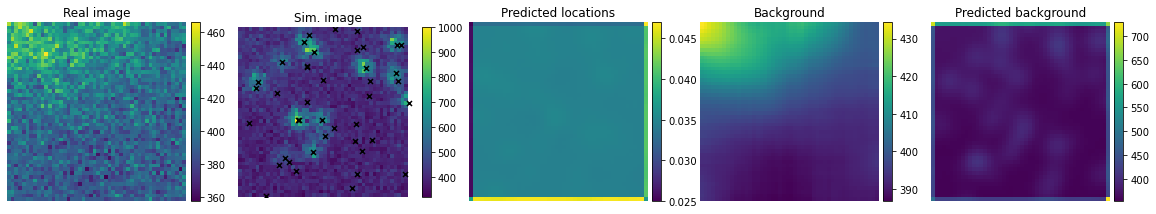

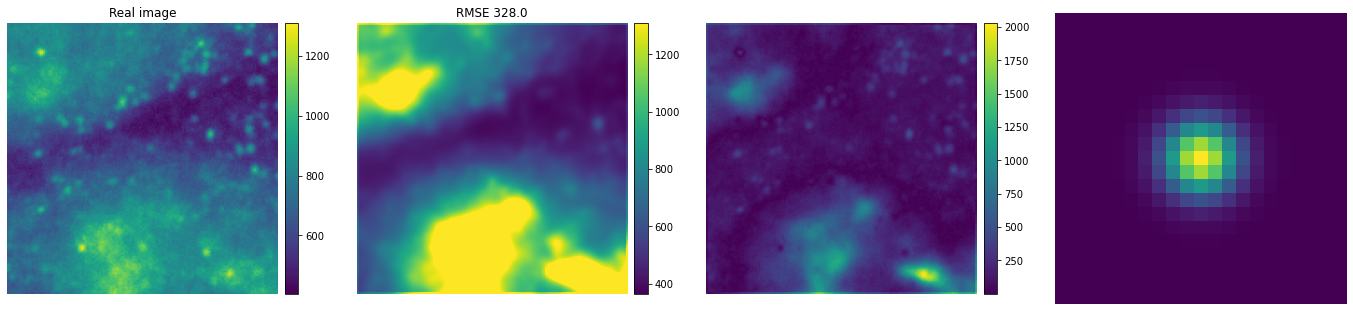

tensor([[[[[1.6325]]],


         [[[1.6959]]],


         [[[1.6547]]],


         [[[1.6834]]],


         [[[1.6629]]],


         [[[1.7340]]],


         [[[1.6248]]],


         [[[1.7017]]],


         [[[1.6877]]],


         [[[1.7211]]],


         [[[1.6897]]],


         [[[1.6793]]],


         [[[1.6695]]],


         [[[1.6932]]],


         [[[1.7111]]],


         [[[1.6609]]]]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)
tensor([[[[[1.6877]]]]], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[[[[1.6330]]],


         [[[1.6962]]],


         [[[1.6574]]],


         [[[1.6836]]],


         [[[1.6631]]],


         [[[1.7351]]],


         [[[1.6249]]],


         [[[1.7035]]],


         [[[1.6923]]],


         [[[1.7223]]],


         [[[1.6922]]],


         [[[1.6797]]],


         [[[1.6715]]],


         [[[1.6973]]],


         [[[1.7135]]],


         [[[1.6612]]]]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)
tensor([[[[[1.6962]]]]], device='cuda:0'

tensor([[[[[1.6369]]],


         [[[1.7158]]],


         [[[1.7004]]],


         [[[1.7137]]],


         [[[1.6641]]],


         [[[1.7433]]],


         [[[1.6468]]],


         [[[1.7301]]],


         [[[1.7260]]],


         [[[1.7437]]],


         [[[1.7419]]],


         [[[1.6830]]],


         [[[1.6887]]],


         [[[1.7279]]],


         [[[1.7510]]],


         [[[1.6633]]]]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)
tensor([[[[[1.6887]]]]], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[[[[1.6370]]],


         [[[1.7163]]],


         [[[1.7048]]],


         [[[1.7148]]],


         [[[1.6641]]],


         [[[1.7436]]],


         [[[1.6479]]],


         [[[1.7309]]],


         [[[1.7269]]],


         [[[1.7453]]],


         [[[1.7449]]],


         [[[1.6831]]],


         [[[1.6934]]],


         [[[1.7287]]],


         [[[1.7544]]],


         [[[1.6633]]]]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)
tensor([[[[[1.7287]]]]], device='cuda:0'

tensor([[[[[1.6387]]],


         [[[1.7203]]],


         [[[1.7533]]],


         [[[1.7639]]],


         [[[1.6667]]],


         [[[1.7651]]],


         [[[1.6560]]],


         [[[1.7418]]],


         [[[1.7532]]],


         [[[1.7791]]],


         [[[1.7688]]],


         [[[1.6878]]],


         [[[1.7326]]],


         [[[1.7591]]],


         [[[1.8032]]],


         [[[1.6715]]]]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)
tensor([[[[[1.7532]]]]], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[[[[1.6388]]],


         [[[1.7204]]],


         [[[1.7548]]],


         [[[1.7686]]],


         [[[1.6687]]],


         [[[1.7672]]],


         [[[1.6563]]],


         [[[1.7424]]],


         [[[1.7565]]],


         [[[1.7805]]],


         [[[1.7696]]],


         [[[1.6882]]],


         [[[1.7340]]],


         [[[1.7602]]],


         [[[1.8066]]],


         [[[1.6723]]]]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)
tensor([[[[[1.6723]]]]], device='cuda:0'

tensor([[[[[1.6403]]],


         [[[1.7352]]],


         [[[1.7661]]],


         [[[1.8186]]],


         [[[1.6836]]],


         [[[1.7828]]],


         [[[1.6597]]],


         [[[1.7731]]],


         [[[1.7822]]],


         [[[1.7927]]],


         [[[1.8001]]],


         [[[1.6934]]],


         [[[1.7482]]],


         [[[1.7954]]],


         [[[1.8421]]],


         [[[1.7439]]]]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)
tensor([[[[[1.7661]]]]], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[[[[1.6405]]],


         [[[1.7364]]],


         [[[1.7687]]],


         [[[1.8213]]],


         [[[1.6841]]],


         [[[1.7833]]],


         [[[1.6602]]],


         [[[1.7757]]],


         [[[1.7832]]],


         [[[1.7935]]],


         [[[1.8023]]],


         [[[1.6941]]],


         [[[1.7512]]],


         [[[1.7984]]],


         [[[1.8447]]],


         [[[1.7472]]]]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)
tensor([[[[[1.7757]]]]], device='cuda:0'

tensor([[[[[1.6424]]],


         [[[1.7450]]],


         [[[1.7879]]],


         [[[1.8528]]],


         [[[1.6985]]],


         [[[1.7995]]],


         [[[1.7093]]],


         [[[1.8229]]],


         [[[1.8034]]],


         [[[1.8000]]],


         [[[1.8183]]],


         [[[1.7159]]],


         [[[1.7894]]],


         [[[1.8291]]],


         [[[1.8803]]],


         [[[1.7721]]]]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)
tensor([[[[[1.7995]]]]], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[[[[1.6428]]],


         [[[1.7453]]],


         [[[1.7886]]],


         [[[1.8540]]],


         [[[1.7000]]],


         [[[1.8028]]],


         [[[1.7139]]],


         [[[1.8260]]],


         [[[1.8068]]],


         [[[1.8004]]],


         [[[1.8189]]],


         [[[1.7176]]],


         [[[1.7909]]],


         [[[1.8316]]],


         [[[1.8817]]],


         [[[1.7731]]]]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)
tensor([[[[[1.6428]]],


         [[[1.7

KeyboardInterrupt: 

In [ ]:
train(cfg=cfg,
     model=model, 
     microscope=micro, 
     post_proc=post_proc,
     dl=decode_dl, 
     optim_dict=optim_dict, 
     eval_dict=eval_dict)

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted 19_MERFISH_routines.ipynb.
Converted 20_MERFISH_visualization.ipynb.
Converted 21_MERFISH_routines_2.ipynb.
Converted 22_MERFISH_codenet.ipynb.
Converted hyper.ipynb.
Converted index.ipynb.


In [ ]:
micro.noise.theta_scale

In [ ]:
micro.noise.theta_par

In [ ]:
for p in micro.noise.parameters():
    print(p)